# Lid-driven cavity flow example
This is an example of using the cavity flow
A two dimensional flow is initialized and simulated. Afterwards, the energy and the velocity field are plotted.

In [16]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch

## Setup
* for running on GPU: device = "cuda". CUDA drivers are required!
* dtype=torch.float32 for single precision - float64 for double precision
* select collision model (here BGKCollision) - try also KBCCollision or RegularizedCollision

### Code:
* Reporters will grab the results in between simulation steps (see reporters.py and simulation.py)
* Output: Column 1: simulation steps, Column 2: time in LU, Column 3: kinetic energy in PU
* Output: separate VTK-file with ux,uy,(uz) and p for every 100. time step in ./output

In [17]:
nmax     = 100000
nconsole = 1000
nreport  = 100
epsilon  = 0.0001 # convergence condition: .1 % relative change
Re = 100

lattice = lt.Lattice(lt.D2Q9, device = torch.device("cuda"), dtype=torch.float64, use_native=False)
flow = lt.Cavity2D(resolution=64, reynolds_number=Re, mach_number=0.05, lattice=lattice)
collision = lt.KBCCollision2D(lattice, tau=flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

Energy = lt.IncompressibleKineticEnergy(lattice, flow)
energy_reporter_internal = lt.ObservableReporter(Energy, interval=nreport, out=None)
simulation.reporters.append(energy_reporter_internal)
simulation.reporters.append(lt.ObservableReporter(Energy, interval=nconsole)) # print energy
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=nreport, filename_base="./data/cavity2d_Re" + "{:.1e}".format(Re) + "/out"))

steps     time     IncompressibleKineticEnergy
steps     time     IncompressibleKineticEnergy


## Run simulations

In [18]:
simulation.initialize_f_neq()
energy_new = 0
mlups = 0
iterations = int(nmax//nconsole)
for _ in range(iterations):
    energy_old = energy_new
    energy_new = Energy(simulation.f).mean()
    mlups += simulation.step(nconsole)
    if abs((energy_new - energy_old)/energy_new) < epsilon:
        print("CONVERGENCE! Less than ", epsilon*100, " % relative change")
        break
    if not energy_new == energy_new:
        print("CRASH")
        break
print("avg MLUPS: ", mlups/iterations)

0 0.0 0.0
1000 0.45105489780439517 0.02415426877493808
2000 0.9021097956087903 0.028671648068138426
3000 1.3531646934131856 0.031322637079697034
4000 1.8042195912175807 0.03309807753110671
5000 2.255274489021976 0.03437484222824673
6000 2.706329386826371 0.03533339181536584
7000 3.157384284630766 0.03607127672144133
8000 3.6084391824351614 0.03664671630413611
9000 4.059494080239556 0.037097934915814514
10000 4.510548978043952 0.03745218926259626
11000 4.961603875848347 0.03773007512187495
12000 5.412658773652742 0.03794767638503556
13000 5.863713671457138 0.03811773854392487
14000 6.314768569261532 0.038250400131348256
15000 6.765823467065927 0.038353716247187725
16000 7.216878364870323 0.03843406553484871
17000 7.667933262674718 0.03849648017637959
18000 8.118988160479113 0.03854491637078903
19000 8.570043058283508 0.03858247475740113
20000 9.021097956087903 0.038611579344668814
21000 9.472152853892299 0.03863412101429827
22000 9.923207751696694 0.03865157219149018
23000 10.3742626495

## Post process
### Energy Reporter
* Grab output of kinetic energy reporter

(291, 3)


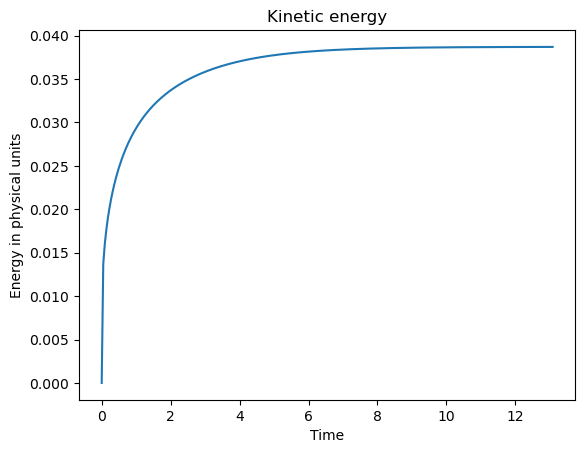

In [19]:
energy = np.array(simulation.reporters[0].out)
print(energy.shape)
plt.plot(energy[:,1],energy[:,2])
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy in physical units')
plt.show()

### Velocity
We calculate the speed in Lettuce units depending on the last 'f'. Then we convert this velocity into physical units. For further investigations the tensor must be converted into a Numpy-Array. The norm of the fractions in x and y direction is plotted afterwards.

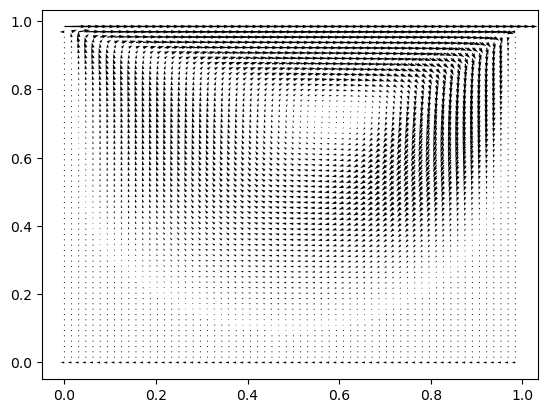

In [20]:
u_x, u_y = flow.units.convert_velocity_to_pu(lattice.u(simulation.f)).cpu().numpy()
x, y = flow.grid
plt.quiver(x.transpose(), y.transpose(), u_x.transpose(), u_y.transpose())